In [11]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
import math

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [12]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [13]:
df_subset = pd.read_csv('df_subset.csv')

In [14]:
pca_df = pd.read_csv('pca_df.csv')

In [15]:
pca_df.head()

,PC1,PC2
0,0.100587,-2.352391
1,2.453818,-2.797303
2,-1.288783,-2.343181
3,1.625696,-2.561994
4,-0.847461,-2.301209


# Density based clustering

## DBSCAN

In [6]:
def combined_scorer(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    unique_labels = np.unique(labels)
    # If there's only one label, return NaN
    if len(unique_labels) == 1:
        return 0
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [7]:
# Define the parameter grid
param_grid = {
    'eps': [0.5, 0.9, 1.0],
    'min_samples': [3, 5, 10],
    'leaf_size': [10, 20, 30, 50]
}

# Initialize DBSCAN
dbscan = DBSCAN()

# Initialize GridSearchCV
grid_search = GridSearchCV(dbscan, param_grid, scoring=combined_scorer, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[CV] END ...............eps=0.5, leaf_size=20, min_samples=3; total time=   4.5s
[CV] END ...............eps=0.5, leaf_size=10, min_samples=3; total time=   4.9s
[CV] END ...............eps=0.5, leaf_size=20, min_samples=3; total time=   5.2s
[CV] END ...............eps=0.5, leaf_size=10, min_samples=5; total time=   5.4s
[CV] END ...............eps=0.5, leaf_size=10, min_samples=5; total time=   5.8s
[CV] END ...............eps=0.5, leaf_size=10, min_samples=3; total time=   6.1s
[CV] END ..............eps=0.5, leaf_size=10, min_samples=10; total time=   6.0s
[CV] END ...............eps=0.5, leaf_size=20, min_samples=5; total time=   4.7s
[CV] END ...............eps=0.5, leaf_size=30, min_samples=3; total time=   4.2s
[CV] END ...............eps=0.5, leaf_size=20, min_samples=5; total time=   4.8s
[CV] END ..............eps=0.5, leaf_size=20, min_samples=10; total time=   5.0s
[CV] END ...............eps=0.5, leaf_size=30, min_samples=5; total time=   4.5s
[CV] END ...............eps=

GridSearchCV(cv=2, estimator=DBSCAN(), n_jobs=-1,
             param_grid={'eps': [0.5, 0.9, 1.0], 'leaf_size': [10, 20, 30, 50],
                         'min_samples': [3, 5, 10]},
             scoring=<function combined_scorer at 0x7f967a79cea0>, verbose=2)

this gives a lot of 0 because the silhouette index needs at least 2 labels to be abke to compute the index and in most cases the algorithm gave just one label

In [9]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'eps': 0.5, 'leaf_size': 10, 'min_samples': 10}
Best Silhouette Score: 0.21788035977371006


In [44]:
# Define the DBSCAN parameters
eps = 0.5
leaf_size = 10
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size)

# Fit the model to the data
dbscan.fit(pca_df)

# Get the labels of the data points
labels = dbscan.labels_


In [45]:
with open('results/density_based/dbscan.pickle', 'wb') as f:
    pickle.dump(dbscan, f)

In [12]:
with open('results/density_based/dbscan.pickle', 'rb') as f:
    dbscan = pickle.load(f)

In [46]:
pca_df = pca_df[['PC1', 'PC2']]

In [47]:
labels = dbscan.labels_+1

pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [48]:
pca_df['cluster_label'].unique()

array([1])

In [49]:
pca_df.to_csv('results/density_based/csv_labels_cut_raw/DBSCAN.csv', index=False)

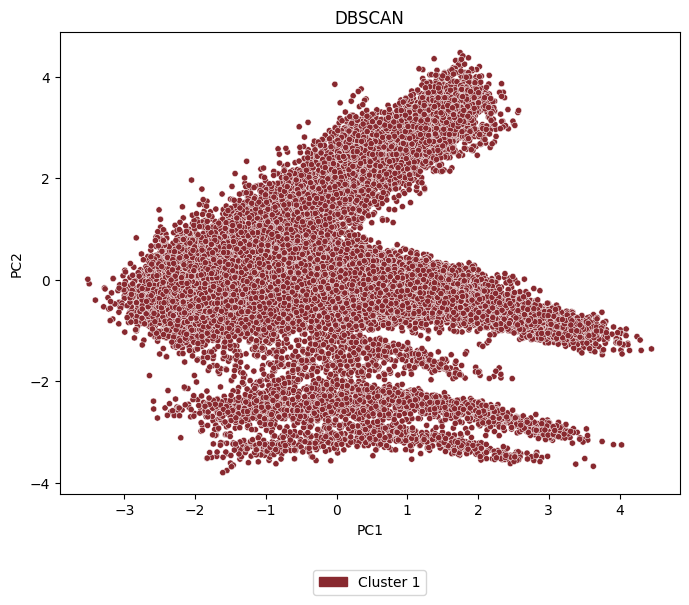

In [50]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

this behaviour was expected due to the already known faults of density based algorithms in high dimensional data, large data sets and relatively equal density

In [18]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster_label labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,1
1,2.453818,-2.797303,11,1
2,-1.288783,-2.343181,11,1
3,1.625696,-2.561994,11,1
4,-0.847461,-2.301209,11,1


In [19]:
pca_df['cluster_label'].unique()

array([1])

In [20]:
pca_df.to_csv('results/density_based/labels_most_common/DBSCAN.csv', index=False)

In [21]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()

In [22]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,1
1,12,-0.678988,-3.266842,1
2,13,-0.094271,-0.236147,1
3,14,1.630648,-0.165246,1
4,15,-0.194524,-0.086996,1
...,...,...,...,...
72,510,0.327813,2.326485,1
73,511,0.751870,2.981085,1
74,512,1.403833,3.298936,1
75,513,1.153314,2.070412,1


In [23]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


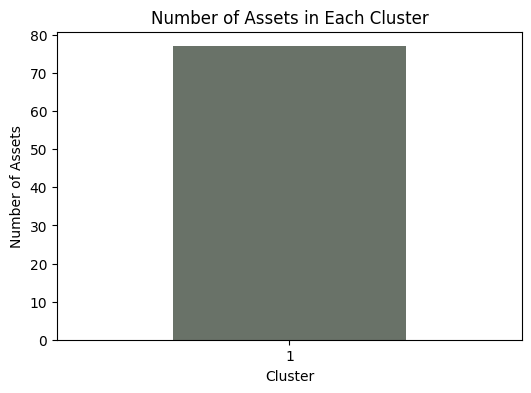

In [24]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [25]:
pca_df = pca_df.loc[:, :'PC2']

## OPTICS

In [16]:
# Define the parameter grid
param_grid = {
    'min_samples': [3, 5, 10],
    'min_cluster_size': [math.ceil(len(pca_df)/120), math.ceil(len(pca_df)/80), math.ceil(len(pca_df)/10)],
    'leaf_size': [10, 20, 30]
}

# Initialize DBSCAN
optics = OPTICS()

# Initialize GridSearchCV
grid_search = GridSearchCV(optics, param_grid, scoring=combined_scorer, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END .leaf_size=10, min_cluster_size=405, min_samples=10; total time= 2.5min
[CV] END ..leaf_size=10, min_cluster_size=405, min_samples=5; total time= 2.6min
[CV] END ..leaf_size=10, min_cluster_size=405, min_samples=3; total time= 2.7min
[CV] END .leaf_size=10, min_cluster_size=405, min_samples=10; total time= 2.7min
[CV] END ..leaf_size=10, min_cluster_size=405, min_samples=5; total time= 2.8min
[CV] END ..leaf_size=10, min_cluster_size=608, min_samples=3; total time= 2.8min
[CV] END ..leaf_size=10, min_cluster_size=608, min_samples=3; total time= 2.8min
[CV] END ..leaf_size=10, min_cluster_size=405, min_samples=3; total time= 2.8min
[CV] END .leaf_size=10, min_cluster_size=608, min_samples=10; total time= 2.5min
[CV] END ..leaf_size=10, min_cluster_size=608, min_samples=5; total time= 2.8min
[CV] END .leaf_size=10, min_cluster_size=608, min_samples=10; total time= 2.7min
[CV] END .leaf_size=10, min_cluster_size=4859, m

GridSearchCV(cv=2, estimator=OPTICS(), n_jobs=-1,
             param_grid={'leaf_size': [10, 20, 30],
                         'min_cluster_size': [405, 608, 4859],
                         'min_samples': [3, 5, 10]},
             scoring=<function combined_scorer at 0x7f967a79cea0>, verbose=2)

In [19]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'leaf_size': 10, 'min_cluster_size': 405, 'min_samples': 3}
Best Clustering Score: 1.8569543749964161


In [18]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_min_cluster_size,param_min_samples,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,75.659750,2.972295,89.807488,2.125706,10,405,3,"{'leaf_size': 10, 'min_cluster_size': 405, 'mi...",1.656065,2.057843,1.856954,0.200889,1
1,73.324949,2.405031,88.986339,1.068013,10,405,5,"{'leaf_size': 10, 'min_cluster_size': 405, 'mi...",2.088448,0.640889,1.364668,0.723779,7
2,74.586405,0.762620,82.578531,6.560877,10,405,10,"{'leaf_size': 10, 'min_cluster_size': 405, 'mi...",0.000000,0.640714,0.320357,0.320357,19
3,73.341663,0.086576,94.182389,0.977123,10,608,3,"{'leaf_size': 10, 'min_cluster_size': 608, 'mi...",1.656065,2.057843,1.856954,0.200889,1
4,81.041236,2.524812,91.866213,2.626066,10,608,5,"{'leaf_size': 10, 'min_cluster_size': 608, 'mi...",2.088448,0.640889,1.364668,0.723779,7
5,74.781045,1.684406,82.127497,7.451861,10,608,10,"{'leaf_size': 10, 'min_cluster_size': 608, 'mi...",0.000000,0.640714,0.320357,0.320357,19
6,73.268154,1.221967,89.604869,2.711310,10,4859,3,"{'leaf_size': 10, 'min_cluster_size': 4859, 'm...",1.656065,0.647930,1.151998,0.504068,16
7,72.492905,0.870604,92.333152,0.928458,10,4859,5,"{'leaf_size': 10, 'min_cluster_size': 4859, 'm...",2.088448,0.640889,1.364668,0.723779,7
8,79.204635,5.012200,79.470436,4.189332,10,4859,10,"{'leaf_size': 10, 'min_cluster_size': 4859, 'm...",0.000000,0.640714,0.320357,0.320357,19
9,76.559577,0.275127,89.844485,1.318170,20,405,3,"{'leaf_size': 20, 'min_cluster_size': 405, 'mi...",1.656065,2.057843,1.856954,0.200889,1


In [20]:
optics = OPTICS(min_samples=10, min_cluster_size=405, leaf_size=3).fit(pca_df[['PC1', 'PC2']])

In [21]:
with open('results/density_based/optics.pickle', 'wb') as f:
    pickle.dump(optics, f)

In [31]:
with open('results/density_based/optics.pickle', 'rb') as f:
    optics = pickle.load( f)

In [22]:
optics_labels = optics.labels_

In [23]:
pca_df['cluster_label'] = optics_labels
pca_df['asset_id'] = df_subset['asset_id']
pca_df.head()

,PC1,PC2,cluster_label,asset_id
0,0.100587,-2.352391,0,11
1,2.453818,-2.797303,0,11
2,-1.288783,-2.343181,0,11
3,1.625696,-2.561994,0,11
4,-0.847461,-2.301209,0,11


In [24]:
pca_df['cluster_label'].nunique()

1

In [25]:
pca_df.to_csv('results/density_based/csv_labels_cut_raw/OPTICS.csv', index=False)

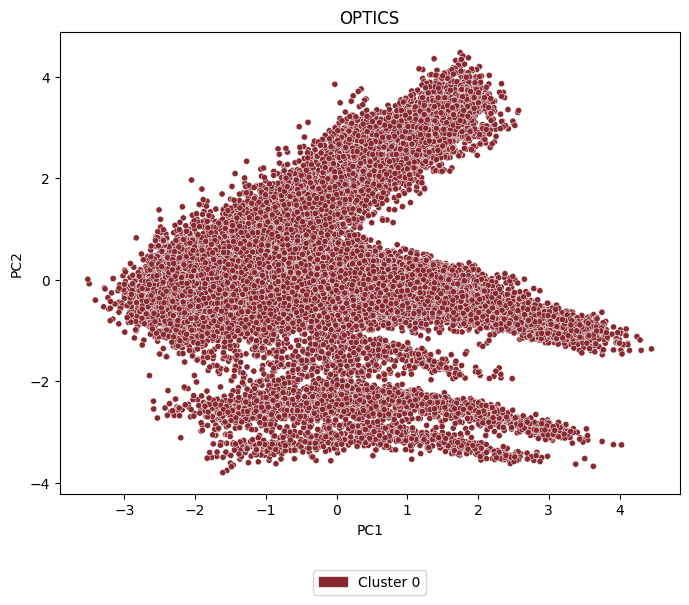

In [26]:
n_clusters = pca_df['cluster_label'].nunique()
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('OPTICS')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(optics_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=100)
plt.show()

In [27]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster_label labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.100587,-2.352391,11,0
1,2.453818,-2.797303,11,0
2,-1.288783,-2.343181,11,0
3,1.625696,-2.561994,11,0
4,-0.847461,-2.301209,11,0


In [28]:
pca_df['cluster_label'].unique()

array([0])

In [29]:
pca_df.to_csv('results/density_based/labels_most_common/OPTICS.csv', index=False)

In [30]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.100587,-2.352391,0
1,12,-0.678988,-3.266842,0
2,13,-0.094271,-0.236147,0
3,14,1.630648,-0.165246,0
4,15,-0.194524,-0.086996,0
...,...,...,...,...
72,510,0.327813,2.326485,0
73,511,0.751870,2.981085,0
74,512,1.403833,3.298936,0
75,513,1.153314,2.070412,0


In [31]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


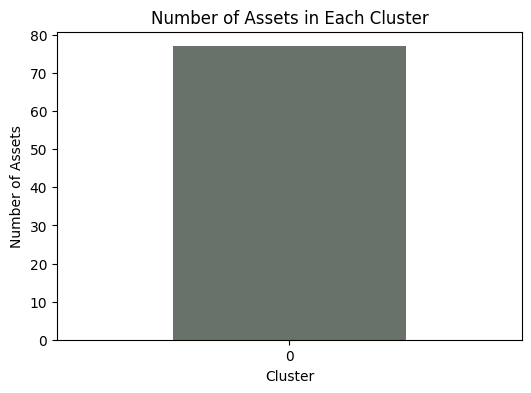

In [32]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()